In [6]:
import toml
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import numpy as np
from loguru import logger

from slopes.__main__ import main
from slopes.__main__ import setup_wbt
from slopes.__main__ import load_input
from slopes.__main__ import process_topography, delineate_reaches, smooth_flowlines, compute_profiles
from slopes.raster.raster_utils import finite_unique

logger.enable('slopes')

In [7]:
params = toml.load("../sample_params/params_10m.toml")
wbt = setup_wbt("../working_dir/")

In [8]:
dem, flowlines = load_input("../data/test_sites_10m/1801010701-dem.tif", "../data/test_sites_10m/1801010701-flowlines.shp")

In [9]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt, params['sigma'])

In [10]:
dataset, flowlines_reaches = delineate_reaches(
    dataset, aligned_flowlines, wbt, params['num_points'], params['spacing'], params['minsize'], params['window']
)

2024-11-11 13:12:20.398 | INFO     | slopes.reach.reaches:delineate_reaches:26 - Rough out valley floors
2024-11-11 13:12:21.655 | INFO     | slopes.reach.reaches:delineate_reaches:28 - Segment into reaches
2024-11-11 13:12:21.656 | INFO     | slopes.reach.reaches:reach_subbasins:39 - get points that represent the breaks
2024-11-11 13:12:21.657 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Splitting 1.0 into reaches, 1/71 1.41%
2024-11-11 13:12:22.488 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Splitting 2.0 into reaches, 2/71 2.82%
2024-11-11 13:12:23.054 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Splitting 3.0 into reaches, 3/71 4.23%
2024-11-11 13:12:24.030 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Splitting 4.0 into reaches, 4/71 5.63%
2024-11-11 13:12:24.544 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Splitting 5.0 into reaches, 5/71 7.04%
2024-11-11 13:12:24.887 | INFO     | slopes.reach.reaches:_compute_reaches:68 - Sp

In [11]:
flowlines = smooth_flowlines(flowlines_reaches)

In [12]:
profiles = compute_profiles(flowlines, dataset, params['line_spacing'], params['line_width'], 
                            params['point_spacing'], dataset['subbasin'], params['min_hand_jump'], params['ratio'], params['min_distance'])

In [33]:
profile = profiles.loc[(profiles['streamID'] == 6600) & (profiles['xsID'] == 225)]

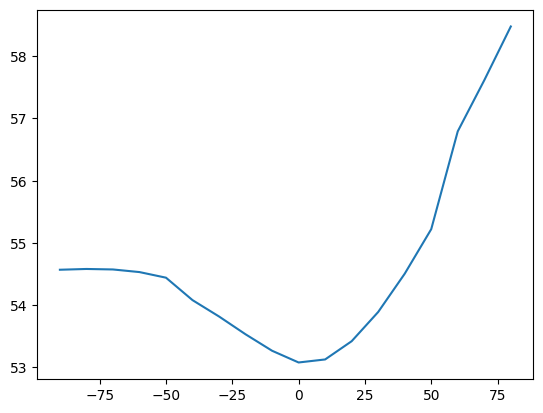

In [48]:
fig, ax = plt.subplots()
ax.plot(profile['alpha'], profile['dem'])

In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import signal
from tqdm import tqdm

from slopes.profile.split import split_profile

def classify_profile_slope_threshold(profile, slope_threshold):
    """
    Splits the cross section profile and finds the wallpoint for each side 
    """
    profile['wallpoint'] = False

    pos, neg = split_profile(profile, duplicate_center=True)
    pos_wall_loc = _find_wall_half(pos, slope_threshold)
    neg_wall_loc = _find_wall_half(neg, slope_threshold)

    if pos_wall_loc is not None:
        profile.loc[pos_wall_loc, "wallpoint"] = True
    if neg_wall_loc is not None:
        profile.loc[neg_wall_loc, "wallpoint"] = True
    return profile

def _find_wall_half(half_profile, slope_threshold):
    """
    returns wall point loc if any
    """
    # add first and last point as bps
    half_profile.loc[half_profile.index[0], 'bp'] = True # this is the stream
    half_profile.loc[half_profile.index[-1], 'bp'] = True

    positional_indices = np.where(half_profile['bp'])[0]

    for i,position in enumerate(positional_indices):
        if i == (len(positional_indices) - 1): # final index
            break
        
        next_pos = positional_indices[i+1]
        median_slope = half_profile['slope'].iloc[position: next_pos+1].median()

        if median_slope > slope_threshold:
            return half_profile.index[position]
    return None

In [46]:
processed_dfs = []
for (streamID, xsID), profile in tqdm(profiles.groupby(['streamID', 'xsID'])):
    classified = profile.copy()
    classified['bp'] = False
    peaks = signal.find_peaks(-classified['curvature'], height=0.)[0]
    classified.loc[profile.index[peaks], 'bp'] = True

    classified = classify_profile_slope_threshold(classified, 10)
    processed_dfs.append(classified)

processed_df = gpd.GeoDataFrame(pd.concat(processed_dfs, ignore_index=True))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8595/8595 [00:18<00:00, 469.35it/s]


In [47]:
processed_df.to_file('process.shp')

/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/ipykernel_3404/2379643442.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  processed_df.to_file('process.shp')
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-mqMb1mKH-py3.10/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'conditioned_dem' to 'conditione'
  ogr_write(
